# X-PSI 101 - For Beginners

This tutorial provides a very basic overview of how you can use X-PSI. It models a single hot spot on a neutron star surface and perfoms sampling for parameter estimation. This is a very simplistic model, but gives a very general example for how one can use X-PSI. It allows you to browse all of the different classes available in X-PSI, free of most of the technical details found in the other notebooks. The same steps are followed in the Modeling tutorial, with additional information and a more complex model. 

To run this tutorial, all data files should be available in in the directory `examples/examples_modeling_tutorial/model_data/`.

In [1]:
%matplotlib inline

import os
import numpy as np
import math
import time

from matplotlib import rcParams
rcParams['text.usetex'] = False
rcParams['font.size'] = 14.0

import xpsi

from xpsi.global_imports import gravradius
from xpsi.utilities import PlottingLibrary as XpsiPlot

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 3.1.3               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Imported emcee version: 3.1.4
Imported PyMultiNest.
Imported UltraNest.
Imported GetDist version: 1.4.7
Imported nestcheck version: 0.2.1


## Step #1: Data and Instrument Response Files

### Data

Let us load the dataset we wish to model. Here a synthetic data set that we generated in advance is called with the ``Data`` class, and we know the fictitious exposure time:

In [2]:
data = xpsi.Data(counts = np.loadtxt('../../examples/examples_modeling_tutorial/model_data/synthetic_ST_realisation.dat', dtype=np.double),
                channels=np.arange(20,201),
                phases=np.linspace(0.0, 1.0, 33),
                first=0, last=180,
                exposure_time=226029523.452384)

Setting channels for event data...
Channels set.


For real data, the X-ray telescope processing pipeline usually results in an event file (EVT) or spectrum (PHA or PI) in FITS format. X-PSI can use both as input (as well as text files), but there is no timing (pulse phase) information in a spectrum file. These files can be loaded with `xpsi.Data.load(file_path,n_phases=32, channels=None, phase_column='PULSE_PHASE', channel_column='PI')` where :
- `file_path` points to an EVT or PHA or PI file
- `n_phase` is the number of phase bins to divide the data into (for EVT files)
- `channels` gives the list of channels to extract
- `phase_column` is the column to take the phase values from (for EVT files)
- `channel_column` is the column to take the channel values from (for EVT files)

Let's take a look at the data that we aim to model. We can plot it with a built-in function :

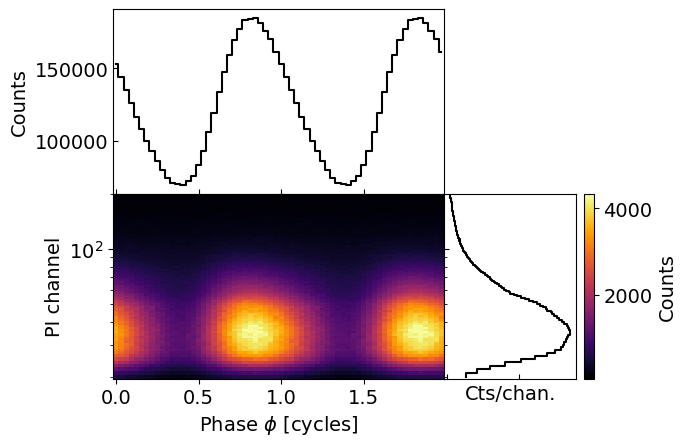

In [3]:
fig, axs = data.plot( dpi=100 , colormap='inferno' , num_rot=2)

The central plot shows the phase-energy (or phase-channel) pulse profile, caused by the emission from a hot spot on the surface of the neutron star. The right panel is the spectrum (integrated over phases), while the top panel is the bolometric pulse-profile (integrated over channels).

### Instrument

We then load an instrument object with the response files of our favourite telescope (NICER in this example), by calling the ``Instrument`` class. This lets us transform incident fluxes into expected counts/channel.

In [4]:
NICER = xpsi.Instrument.from_ogip_fits(RMF_path='nicer_20170601v003.rmf',
                                        ARF_path='nicer_20170601v005.arf',
                                        datafolder='../../examples/examples_modeling_tutorial/model_data/')

# here we manually trim the instrument response files to restrict to channels 20:200
NICER.trim_response(min_channel=20, max_channel=200, tolerance=1e-4)    

Loading instrument response matrix from OGIP compliant files...
Triming the response matrix because it contains columns with only 0 values.
 Now min_channel=9 and max_channel=1500
Setting channels for loaded instrument response (sub)matrix...
Channels set.
An empty subspace was created. This is normal behavior - no parameters were supplied.
Response matrix loaded.
Trimming instrument response...
Setting channels for loaded instrument response (sub)matrix...
Channels set.
Triming channels of the response matrix because a smaller channel range has been requested.
 Now min_channel=20 and max_channel=200
Triming energy inputs of the response matrix with tolerance 0.0001.
 Now min_energy=0.10000000149011612 and max_energy=9.6850004196167
Instrument response trimmed.


A lot of instrument-related information and plotting options can be found in the notebook Instrument synergy.

### Signal

We create a ``Signal`` class object to store the properties of the instrument and dataset. It is currently the **only** basic class which also requires definition of a Custom class to implement the background marginalisation method. Here we choose to use the default class, but other methods have been implemented, available in the `likelihoods/` directory.  It can also store background information (either through a `Background` model or a support file, loaded the same way as `Data`) and interstellar attenuation (using the `Interstellar` class, which also requires a Custom class to compute the attenuation).

In [5]:
from xpsi.likelihoods.default_background_marginalisation import eval_marginal_likelihood
from xpsi.likelihoods.default_background_marginalisation import precomputation

class CustomSignal(xpsi.Signal):
    """
    
    A custom calculation of the logarithm of the likelihood.
    We extend the :class:`~xpsi.Signal.Signal` class to make it callable.
    We overwrite the body of the __call__ method. The docstring for the
    abstract method is copied.
    
    """

    def __init__(self, workspace_intervals = 1000, epsabs = 0, epsrel = 1.0e-8,
                 epsilon = 1.0e-3, sigmas = 10.0, support = None, **kwargs):
        """ Perform precomputation.
        
        :params ndarray[m,2] support:
            Prior support bounds for background count rate variables in the
            :math:`m` instrument channels, where the lower bounds must be zero
            or positive, and the upper bounds must be positive and greater than
            the lower bound. Alternatively, setting the an upper bounds as
            negative means the prior support is unbounded and the flat prior
            density functions per channel are improper. If ``None``, the lower-
            bound of the support for each channel is zero but the prior is
            unbounded.
        
        """

        super(CustomSignal, self).__init__(**kwargs)

        try:
            self._precomp = precomputation(self._data.counts.astype(np.int32))
        except AttributeError:
            print('Warning: No data... can synthesise data but cannot evaluate a '
                  'likelihood function.')
        else:
            self._workspace_intervals = workspace_intervals
            self._epsabs = epsabs
            self._epsrel = epsrel
            self._epsilon = epsilon
            self._sigmas = sigmas
            
            if support is not None:
                self._support = support
            else:
                self._support = -1.0 * np.ones((self._data.counts.shape[0],2))
                self._support[:,0] = 0.0

    def __call__(self, *args, **kwargs):
        self.loglikelihood, self.expected_counts, self.background_signal, self.background_given_support = \
                eval_marginal_likelihood(self._data.exposure_time,
                                          self._data.phases,
                                          self._data.counts,
                                          self._signals,
                                          self._phases,
                                          self._shifts,
                                          self._precomp,
                                          self._support,
                                          self._workspace_intervals,
                                          self._epsabs,
                                          self._epsrel,
                                          self._epsilon,
                                          self._sigmas,
                                          kwargs.get('llzero'),
                                          allow_negative=(False))

In [6]:
signal = CustomSignal(data = data,
                        instrument = NICER,
                        background = None,
                        interstellar = None,
                        workspace_intervals = 1000,
                        cache = True,
                        epsrel = 1.0e-8,
                        epsilon = 1.0e-3,
                        sigmas = 10.0,
                        support = None)

Creating parameter:
    > Named "phase_shift" with fixed value 0.000e+00.
    > The phase shift for the signal, a periodic parameter [cycles].


## Step #2: Create an emission model

### Constructing a star

We now need to build our star model. The building blocks of our very simple star are:

* the [Spacetime](spacetime.rst#xpsi.Spacetime.Spacetime) class, a model of the ambient Schwarzschild spacetime;
* the [HotRegion](hotregion.rst#xpsi.HotRegion.HotRegion) class, a model for a hot spot on the surface of the neutron star;
* the [Photosphere](photosphere.rst#xpsi.Photosphere.Photosphere) class, a model of the rotating neutron star photosphere.

In this example, we assume that only one hot spot is responsible for the emission of the `Photosphere` in the X-ray band for our instrument. Hence, we use just a simple `HotRegion` model.

To instantiate each of those basic units, we need to define the relevant parameters (including mass, radius, hot spot size, etc). Each of the parameters must be defined in one of two ways :
- either by providing bounds, in which case the parameter is free to move between the given bounds; 
- or as a value, in which case the parameter is fixed at said value. 

If both bounds **and** a value are provided for one parameter, this parameter will have the given value as an initial value but will be set free to vary between the bounds. The required and optional parameter names can be found in the class API.

#### The ambient spacetime

In [7]:
## First example : we provide ONLY values for all of the parameters, and no bounds. In this case, all the parameters are fixed.

values = dict(distance = 0.150,         # (Earth) distance
                mass = 1.5,             # mass
                radius = 12.0,          # equatorial radius
                cos_inclination = 0.5,  # (Earth) inclination to rotation axis
                frequency = 300. )      # spin frequency

spacetime = xpsi.Spacetime(bounds={}, values=values)

Creating parameter:
    > Named "frequency" with fixed value 3.000e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with fixed value 1.500e+00.
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with fixed value 1.200e+01.
    > Coordinate equatorial radius [km].
Creating parameter:
    > Named "distance" with fixed value 1.500e-01.
    > Earth distance [kpc].
Creating parameter:
    > Named "cos_inclination" with fixed value 5.000e-01.
    > Cosine of Earth inclination to rotation axis.


In [8]:
## Another example is to give only bounds for some, only values for others, or both (for the mass here)

bounds = dict(distance = (None, None),                   # Default bounds for (Earth) distance
                mass = (None, None),                     # Default bounds for mass 
                radius = (None, None),                   # Default bounds for equatorial radius
                cos_inclination = (None, None))          # Default bounds for (Earth) inclination to rotation axis

values = dict(frequency=300.0,                           # Fixed spin frequency
              mass=1.4)                                  # mass with initial value

spacetime = xpsi.Spacetime(bounds=bounds, values=values)

Creating parameter:
    > Named "frequency" with fixed value 3.000e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with bounds [1.000e-03, 3.000e+00] and initial value 1.400e+00.
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with bounds [1.000e+00, 2.000e+01].
    > Coordinate equatorial radius [km].
Creating parameter:
    > Named "distance" with bounds [1.000e-02, 3.000e+01].
    > Earth distance [kpc].
Creating parameter:
    > Named "cos_inclination" with bounds [-1.000e+00, 1.000e+00].
    > Cosine of Earth inclination to rotation axis.


For the following example in this tutorial, we will specify bounds for all parameters except for the frequency, which will be fixed.

In [9]:
bounds = dict(distance = (1.0,10.0),                     # distance in kpc
                mass = (1.0, 3.0),                       # mass with default bounds
                radius = (3.0 * gravradius(1.0), 16.0),  # equatorial radius
                cos_inclination = (0.0, 1.0))            # (Earth) inclination to rotation axis

values = dict(frequency=200.0)                          # Fixed spin frequency

spacetime = xpsi.Spacetime(bounds=bounds, values=values)

Creating parameter:
    > Named "frequency" with fixed value 2.000e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with bounds [1.000e+00, 3.000e+00].
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with bounds [4.430e+00, 1.600e+01].
    > Coordinate equatorial radius [km].
Creating parameter:
    > Named "distance" with bounds [1.000e+00, 1.000e+01].
    > Earth distance [kpc].
Creating parameter:
    > Named "cos_inclination" with bounds [0.000e+00, 1.000e+00].
    > Cosine of Earth inclination to rotation axis.


In order to create a ``Photosphere`` object, which will describe the surface emission, we first have to build up the emitting region(s), through a ``HotRegion`` object.

For simplicity, we instantiate a single ``HotRegion`` object with a simple circular hot spot described by one single temperature (the 'ST' model) at the surface. For details of the names and descriptions of more complex regions, check the notebook Hot region complexity.
For this example, the default blackbody atmosphere model is used.

In [10]:
bounds = dict(super_colatitude = (None, None),  # latitude of the hot spot in radians, from north pole (default: 0) to south pole (default: pi)
              super_radius = (None, None),      # radius of the hot spot, in radians (default: between 0 and pi/2 (half of the NS))
              phase_shift = (-0.25, 0.75),      # longitude of the hot spot
              super_temperature = (None, None)) # temperature of the hot spot, default: 3.0 to 7.6, from very cold to very hot

# a simple circular, simply-connected spot
primary = xpsi.HotRegion(bounds=bounds,
                            values={}, # no initial values and no derived/fixed values
                            symmetry=True,
                            omit=False,
                            cede=False,
                            concentric=False,
                            sqrt_num_cells=32,
                            min_sqrt_num_cells=10,
                            max_sqrt_num_cells=64,
                            num_leaves=64,
                            num_rays=200,
                            atm_ext="BB", # default blackbody, other options: "Num4D" or "user"
                            prefix='p')   # unique prefix to identify the region, needed if >1 instances

Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (circular) superseding region [radians].
Creating parameter:
    > Named "phase_shift" with bounds [-2.500e-01, 7.500e-01].
    > The phase of the hot region, a periodic parameter [cycles].
Creating parameter:
    > Named "super_temperature" with bounds [3.000e+00, 7.600e+00].
    > log10(superseding region effective temperature [K]).


We now need to encapsulate the ``HotRegion`` instance in a ``Photosphere`` class.

In [11]:
photosphere = xpsi.Photosphere(hot = primary, elsewhere = None,
                                values=dict(mode_frequency = spacetime['frequency']))

Creating parameter:
    > Named "mode_frequency" with fixed value 2.000e+02.
    > Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz].


#### Star

We can now combine the ambient spacetime, ``Spacetime``, and the embedded photosphere, ``Photosphere``, into a model star represented by an instance of ``Star``, as follows:

In [12]:
star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)

### Prior

We can now make a ``Prior`` object which will contain all of the information and constraints that we have on our parameters *prior* to sampling. The default prior only checks that sampled values are within the given bounds for the free parameters. If more information is available, a Custom class can be created, as follows, to store and apply these constraints during sampling. Here we implement a joint constraint on the gravitational mass and equatorial radius to assign zero prior density to stars which are too compact (for more on compactness limits see  Lattimer & Prakash (2001)).

In [13]:
from scipy.stats import truncnorm

class CustomPrior(xpsi.Prior):
    """ A custom (joint) prior distribution.

    Source: Fictitious
    Model variant: ST-U
        Two single-temperature, simply-connected circular hot regions with
        unshared parameters.

    """

    __derived_names__ = ['compactness', ]
    __draws_from_support__ = 3

    def __init__(self):
        """ Nothing to be done.

        A direct reference to the spacetime object could be put here
        for use in __call__:

        .. code-block::

            self.spacetime = ref

        Instead we get a reference to the spacetime object through the
        a reference to a likelihood object which encapsulates a
        reference to the spacetime object.

        """
        super(CustomPrior, self).__init__() # not strictly required if no hyperparameters

    def __call__(self, p = None):
        """ Evaluate distribution at ``p``.

        :param list p: Model parameter values.

        :returns: Logarithm of the distribution evaluated at ``p``.

        """
        temp = super(CustomPrior, self).__call__(p)
        if not np.isfinite(temp):
            return temp

        # based on contemporary EOS theory
        if not self.parameters['radius'] <= 16.0:
            return -np.inf

        ref = self.parameters.star.spacetime # shortcut

        # limit polar radius to try to exclude deflections >= \pi radians
        # due to oblateness this does not quite eliminate all configurations
        # with deflections >= \pi radians
        R_p = 1.0 + ref.epsilon * (-0.788 + 1.030 * ref.zeta)
        if R_p < 1.76 / ref.R_r_s:
            return -np.inf

        # polar radius at photon sphere for ~static star (static ambient spacetime)
        #if R_p < 1.5 / ref.R_r_s:
        #    return -np.inf

        mu = math.sqrt(-1.0 / (3.0 * ref.epsilon * (-0.788 + 1.030 * ref.zeta)))

        # 2-surface cross-section have a single maximum in |z|
        # i.e., an elliptical surface; minor effect on support, if any,
        # for high spin frequenies
        if mu < 1.0:
            return -np.inf

        ref = self.parameters # redefine shortcut

        return 0.0

    def inverse_sample(self, hypercube=None):
        """ Draw sample uniformly from the distribution via inverse sampling. """

        to_cache = self.parameters.vector

        if hypercube is None:
            hypercube = np.random.rand(len(self))

        # the base method -a uniform sampling within the bounds- is useful, so to avoid writing that code again:
        _ = super(CustomPrior, self).inverse_sample(hypercube)

        ref = self.parameters # shortcut

        # flat priors in cosine of hot region centre colatitudes (isotropy)
        # support modified by no-overlap rejection condition
        idx = ref.index('p__super_colatitude')
        a, b = ref.get_param('p__super_colatitude').bounds
        a = math.cos(a); b = math.cos(b)
        ref['p__super_colatitude'] = math.acos(b + (a - b) * hypercube[idx])

        # restore proper cache
        for parameter, cache in zip(ref, to_cache):
            parameter.cached = cache

        # it is important that we return the desired vector because it is
        # automatically written to disk by MultiNest and only by MultiNest
        return self.parameters.vector

    def transform(self, p, **kwargs):
        """ A transformation for post-processing. """

        p = list(p) # copy

        # used ordered names and values
        ref = dict(zip(self.parameters.names, p))

        # compactness ratio M/R_eq
        p += [gravradius(ref['mass']) / ref['radius']]

        return p

In [14]:
prior = CustomPrior()

An empty subspace was created. This is normal behavior - no parameters were supplied.


### Likelihood

We can now construct and instantiate a ``Likelihood`` object. With this we will be able to do likelihood evaluation using the model components defined above. 

In [15]:
likelihood = xpsi.Likelihood(star = star, signals = signal,
                             prior = prior,
                             num_energies=128,
                             threads=1,
                             externally_updated=False)

We can retrieve the free model parameters:

In [16]:
likelihood

Free parameters
---------------
mass: Gravitational mass [solar masses].
radius: Coordinate equatorial radius [km].
distance: Earth distance [kpc].
cos_inclination: Cosine of Earth inclination to rotation axis.
p__phase_shift: The phase of the hot region, a periodic parameter [cycles].
p__super_colatitude: The colatitude of the centre of the superseding region [radians].
p__super_radius: The angular radius of the (circular) superseding region [radians].
p__super_temperature: log10(superseding region effective temperature [K]).

Note that if you want to modify the definition of the model parameter space you should construct a new ``likelihood`` object, instead of manipulating existing objects, for safety. (You can also restart the kernel, although if this is required it is a bug.)

We can give this object some parameters and compute a likelihood, or compare it to a known likelihood as a check.

In [17]:
p = [1.4,      # mass
     12.0,     # radius 
     5.2,      # distance
     0.4,      # cos_inclination
     0.1,      # p__phase_shift
     0.9,      # p__super_colatitude
     0.2,      # p__super_radius
     6.15]     # p__super_temperature

## You can evaluate the likelihood for the parameters p 
print(likelihood(p, reinitialise=True))   # use reinitialise=True if settings have been changed since the last call of the likelihood (here it is not necessary)

## Or check that you get the expected likelihood value
likelihood.clear_cache()
t = time.time()
likelihood.check(None, [-2.7556722122e+04], 1.0e-6,
                 physical_points=[p])
 
print('time = %.3f s' % (time.time() - t))

-27556.722932725563
Checking likelihood and prior evaluation before commencing sampling...
Not using ``allclose`` function from NumPy.
Using fallback implementation instead.
Checking closeness of likelihood arrays:
-2.7556722933e+04 | -2.7556722122e+04 .....
Closeness evaluated.
Log-likelihood value checks passed on root process.
Checks passed.
time = 0.104 s


Calling the ``Likelihood`` object created (or overwrote) the ``signal.expected_counts`` (counts/chan predicted by the current model) which can be compared to ``signal.data.counts`` (counts/chan from data file). 

### Inspecting functionality

Let's plot our pulse and our hot spot configuration. First, the 1D (bolometric) pulse profile, and the 2D (energy-resolved) pulse profile. 

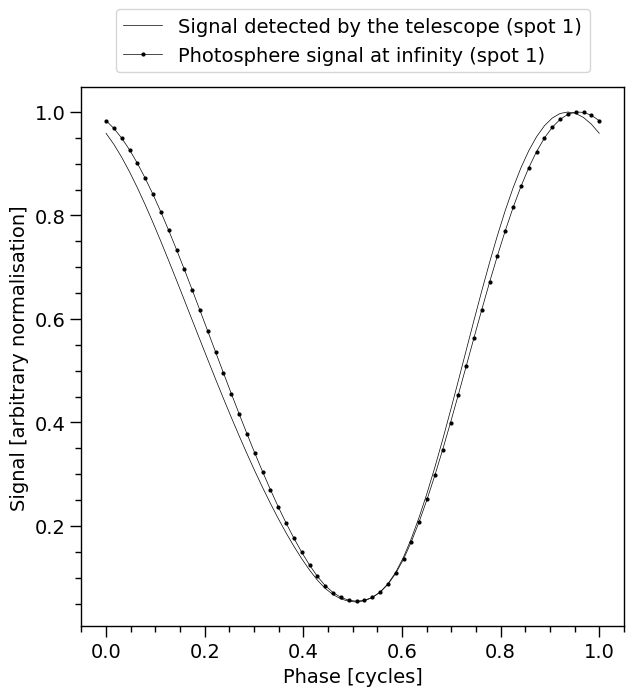

In [18]:
XpsiPlot.plot_1d_pulse(signal=signal,
              photosphere=photosphere,
              photosphere_phases=signal.phases)

Photosphere (the points with the markers) is the signal that is observed outside the potential well of the star. It is the signal that would be observed at infinity in vacuum. The markers represent the phase resolution.
On the other hand, Signal (without markers) is the effective signal that is detected by the telescope (after interstellar absorption and instrument response effects). The latter is compared to the data for the likelihood computation. 

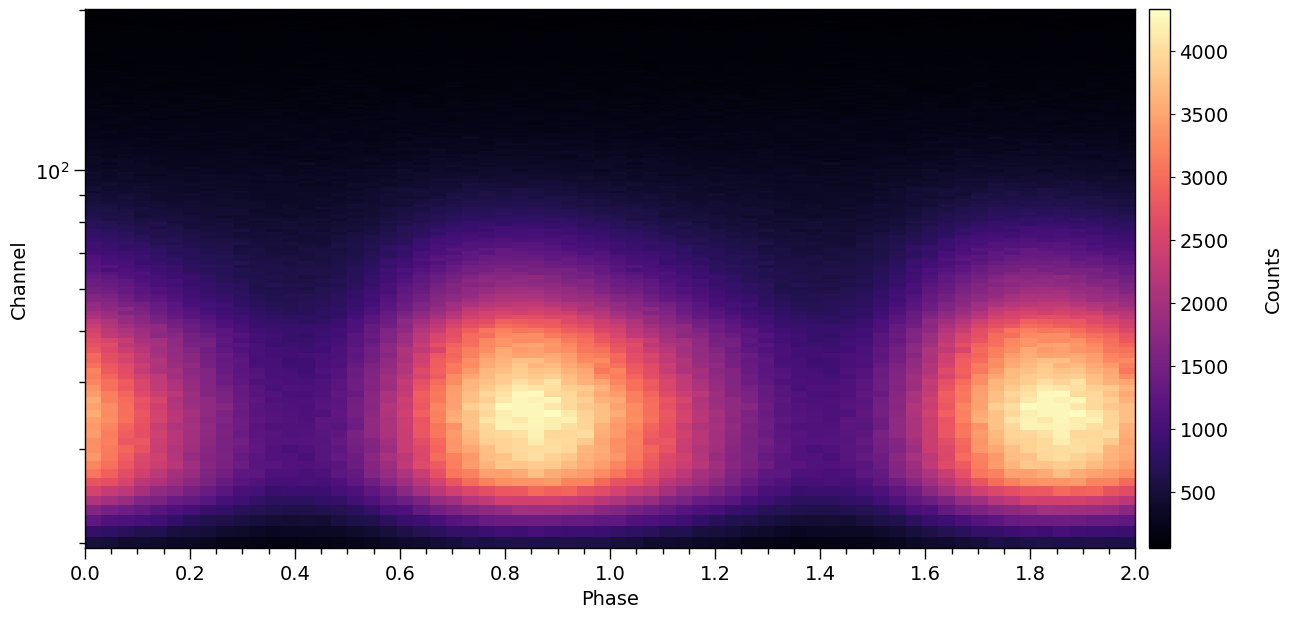

In [19]:
XpsiPlot.plot_2d_pulse(pulse=signal.data.counts,
                       x=data.phases,
                       y=data.channels,
                       rotations=2,
                       ylabel='Channel',
                       cbar_label='Counts',)

We can also use the projection tool to visualize the geometry of the neutron star hot region (see the Emitting Patterns 2D Projection notebook for more information about the tool):

YOU ARE USING 1 HOT SPOT MODEL


<Axes: >

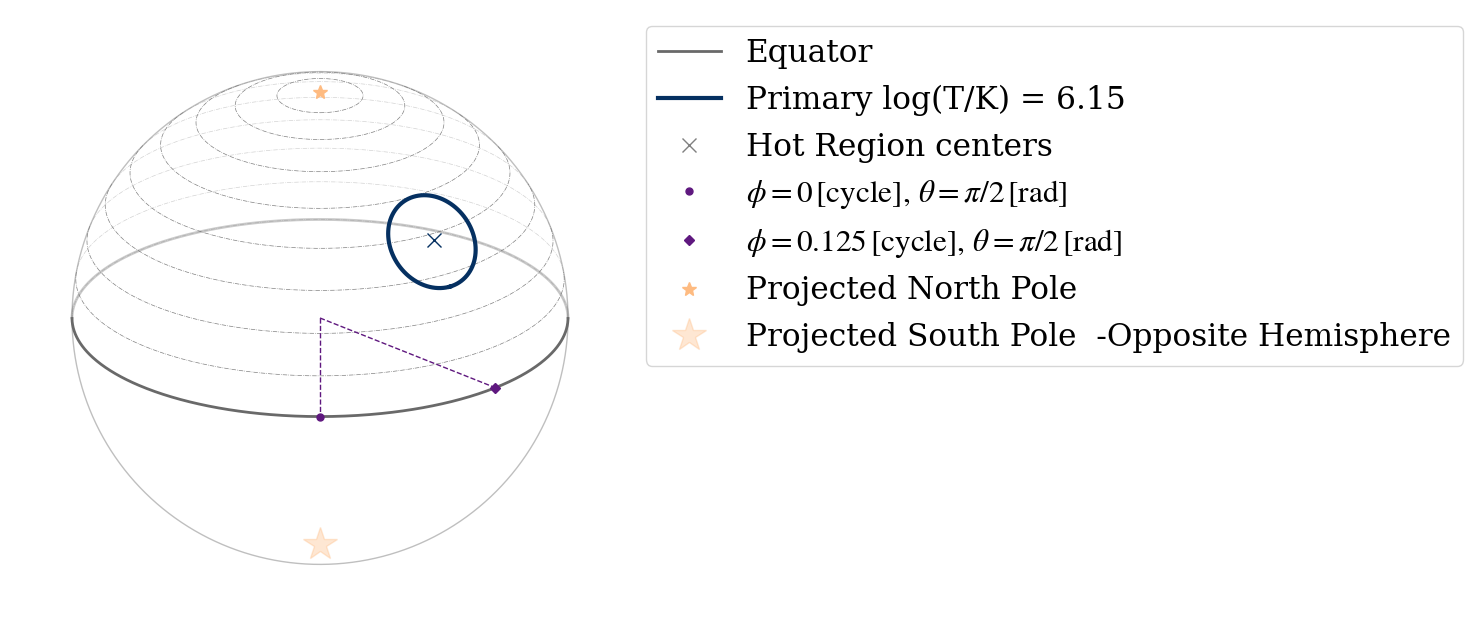

In [20]:
from xpsi.utilities import ProjectionTool
ProjectionTool.plot_projection_general((likelihood),"ST","I","NP")

## Sampling interface

We have constructed and instantiated a ``Likelihood`` object, containing the data and instrument response files, as well as the star model and all of our priors. We are now ready for sampling. Several samplers are availbale in X-PSI for that purpose: [PyMultiNest](https://github.com/JohannesBuchner/PyMultiNest), [emcee](http://emcee.readthedocs.io/en/latest/), or [UltraNest](https://johannesbuchner.github.io/UltraNest/). In this example we will use Multinest, but examples with the other samplers can be found in the Modeling notebook.

### MultiNest

We interface with the nested sampler MultiNest by defining some runtime settings, and then passing those settings together with ``likelihood`` and ``prior`` objects to a wrapper from the ``Sample`` module. We will run the sampler for a specified number (100) of nested replacements (iterations). 

The environment variable ``LD_LIBRARY_PATH`` must be set before launching Jupyter as follows:
    
    $ export LD_LIBRARY_PATH=<path/to/multinest>/lib

Get the parameters that are periodic or wrapped to inform MultiNest of boundary properties:

In [21]:
wrapped_params = [0]*len(likelihood)
wrapped_params[likelihood.index('p__phase_shift')] = 1

In [22]:
os.system("mkdir -p Output")

runtime_params = {'resume': True,
                  'importance_nested_sampling': False,
                  'multimodal': False,
                  'n_clustering_params': None,
                  'outputfiles_basename': './Output/run', # make ./Output directory manually
                  'n_iter_before_update': 5,
                  'n_live_points': 100,
                  'sampling_efficiency': 0.8,
                  'const_efficiency_mode': False,
                  'wrapped_params': wrapped_params,
                  'evidence_tolerance': 0.5,
                  'max_iter': 500,  # manual termination condition for short test
                  'verbose': True}
    
likelihood.threads = 1
likelihood.reinitialise()
likelihood.clear_cache()

# inform source code that parameter objects updated when inverse sampling
likelihood.externally_updated = True

xpsi.Sample.nested(likelihood, prior, **runtime_params)

nested() is deprecated and will be removed in X-PSI v4.0 Please use run_multinest() instead. <class 'DeprecationWarning'>
Commencing integration...
Estimating fractional hypervolume of the unit hypercube with finite prior density:
Requiring 1E+03 draws from the prior support for Monte Carlo estimation...
Drawing samples from the joint prior...
Samples drawn.
The support occupies an estimated 47.2% of the hypervolume within the unit hypercube...
Fractional hypervolume estimated.
Sampling efficiency set to: 1.6960.
 *****************************************************
 MultiNest v3.12
 Copyright Farhan Feroz & Mike Hobson
 Release Nov 2019

 no. of live points =  100
 dimensionality =    8
 resuming from previous job
 *****************************************************
 Starting MultiNest


/tmp/ipykernel_1645567/3575453599.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  eval_marginal_likelihood(self._data.exposure_time,


Acceptance Rate:                        0.462633
Replacements:                                650
Total Samples:                              1405
Nested Sampling ln(Z):            -215698.191886
Acceptance Rate:                        0.447857
Replacements:                                700
Total Samples:                              1563
Nested Sampling ln(Z):            -174751.302430
Acceptance Rate:                        0.438853
Replacements:                                750
Total Samples:                              1709
Nested Sampling ln(Z):            -142274.102299
Acceptance Rate:                        0.421053
Replacements:                                800
Total Samples:                              1900
Nested Sampling ln(Z):            -108017.998532
Acceptance Rate:                        0.411822
Replacements:                                850
Total Samples:                              2064
Nested Sampling ln(Z):             -90605.514305
Acceptance Rate:    

See the MultiNest documentation for details on the parameters, and for typical parameter values used in X-PSI, see the Publications.

Once the sampling is finished, the output files (created in the `Output/` folder here) can be given to the Post-Processing notebook to visualize and plot the posterior distributions of the parameters.

A typical corner plot that can be produced in Post-Processing following a converged sampling is represented below. 

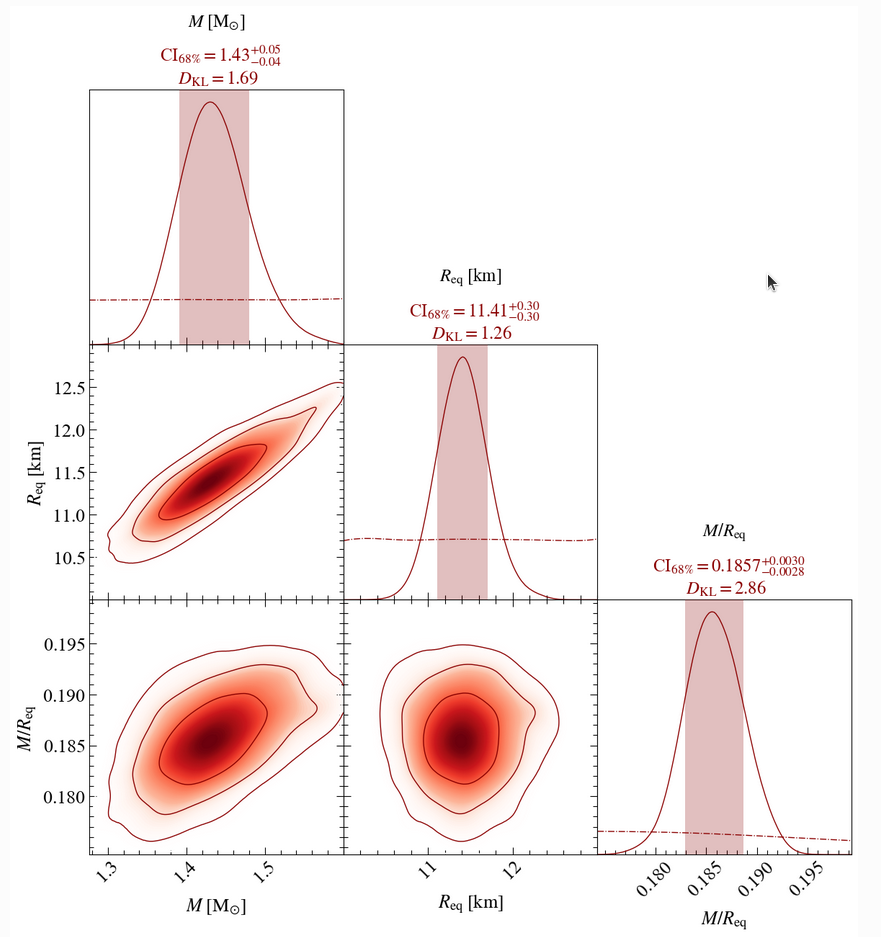

## Summary

In this notebook we showed in a very simple way how to use X-PSI to do pulse profile modeling and parameter inference. We constructed a model of a single hot spot on the neutron star surface, including an instrument response, and combined it with data to form a likelihood object. We then defined priors, which together allowed for posterior sampling and parameter inference.